In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.rename(columns={'Subject Focus': 'SubjectFocus'}, inplace=True)
test.rename(columns={'Subject Focus': 'SubjectFocus'}, inplace=True)
train

Id  SubjectFocus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0             0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db             0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e             0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246             0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2             0     0     0     1   
...                                ...           ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57             0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45             0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20             0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a             0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228             0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  
0              63  
1              42  
2              28  
3              15  
4              72  
...           ...  
9907           15  
9908           70  
9909           20  
9910           20  
9911           30  

[9912 rows x 14 columns]

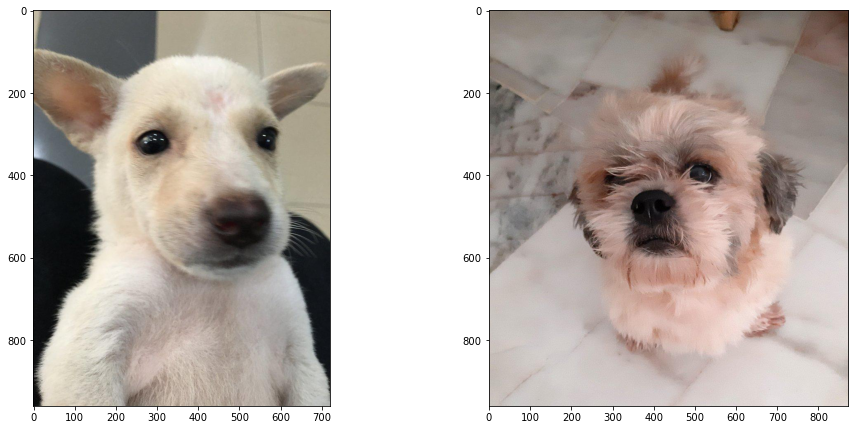

In [4]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + train.Id[23] + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'fe200aff478f55ca4bcf77d9dade1217' + '.jpg')
plt.imshow(img)
plt.show()

In [5]:
predictors = train.columns[1:-1]
X = train[predictors].copy()
y = train.Pawpularity.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_predictors = model.predict(X_val)
mean_absolute_error(y_val, y_predictors)

15.701601470303045

In [6]:
output = pd.DataFrame(test.Id)
# test['Score'] = df.Action * 12 + df.SubjectFocus * 11 + df.Face * 10 + df.Near * 9 + df.Accessory * 8 + df.Blur * 7 + df.Info * 6 + df.Collage * 5 + df.Group * 4 + df.Occlusion * 3 + df.Eyes * 2 + df.Human
X_test = test[predictors].copy()
output['Pawpularity'] = model.predict(X_test)
output

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3    67.000000
1  43a2262d7738e3d420d453815151079e    26.000000
2  4e429cead1848a298432a0acad014c9d    36.000000
3  80bc3ccafcc51b66303c2c263aa38486    37.827586
4  8f49844c382931444e68dffbe20228f4    46.000000
5  b03f7041962238a7c9d6537e22f9b017   100.000000
6  c978013571258ed6d4637f6e8cc9d6a3    30.000000
7  e0de453c1bffc20c22b072b34b54e50f    34.071429

In [7]:
# output.to_csv('submission.csv', index=False)

## Let's try to make it better

### train with alternative "Group" column:

In [8]:
new_train = train.copy()
new_train['Group'] = (train['Group'] == 0).astype(int)
predictors = new_train.columns[1:-1]
X = new_train[predictors].copy()
y = new_train.Pawpularity.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_predictors = model.predict(X_val)
mean_absolute_error(y_val, y_predictors)

15.531704469169949

### train with real "Group" column:

In [9]:
predictors = train.columns[1:-1]
X = train[predictors].copy()
y = train.Pawpularity.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_predictors = model.predict(X_val)
mean_absolute_error(y_val, y_predictors)

15.08394016736125

#### Это значит, что, если на фото несколько животных, то это может иметь отрицательное влияние на Pawpularity

$$ y = b_{0} + b_{1} \cdot x_{1} + ... + b_{12} \cdot x_{12} + \epsilon $$

In [10]:
M = train.sample(n=12)
V1 = M.Pawpularity.values
M1 = M[predictors].values
try:
    np.linalg.solve(M1, V1)
except:
    print('Singular matrix error')   

Singular matrix error


## Проверим фотографии, у которых одинаковые признаки

### Subject Focus

In [11]:
predictors = train.columns[1:-1]
train[(train[predictors].sum(axis=1) == 1) & (train['SubjectFocus'] == 1)]

Id  SubjectFocus  Eyes  Face  Near  \
9495  f56b7ba8c1356db52b38c19960551afc             1     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
9495       0          0      0        0      0          0     0     0   

      Pawpularity  
9495           30

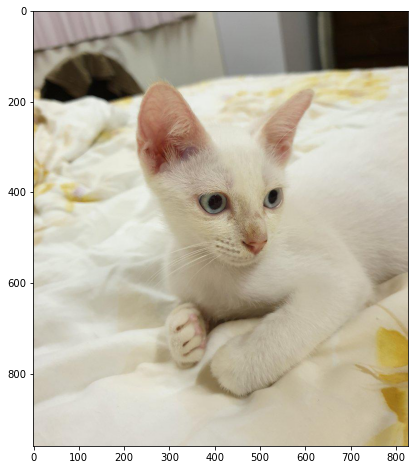

In [12]:
plt.figure(figsize=(8, 8))
img = plt.imread('train/' + 'f56b7ba8c1356db52b38c19960551afc' + '.jpg')
plt.imshow(img)
plt.show()

### Near

In [13]:
train[train[predictors].sum(axis=1) == 1].head(4)

Id  SubjectFocus  Eyes  Face  Near  Action  \
34  00df0a668441b10869f4372fd15c14f5             0     0     0     1       0   
53  014af4e2e2154f171c8a0e2d30ebb420             0     0     0     1       0   
63  0185e6b6800c2af68dc1e055d91517be             0     0     0     1       0   
66  019e7f286c9a3bd4d5a66b662b9465ee             0     0     0     1       0   

    Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
34          0      0        0      0          0     0     0           69  
53          0      0        0      0          0     0     0           21  
63          0      0        0      0          0     0     0           27  
66          0      0        0      0          0     0     0           82

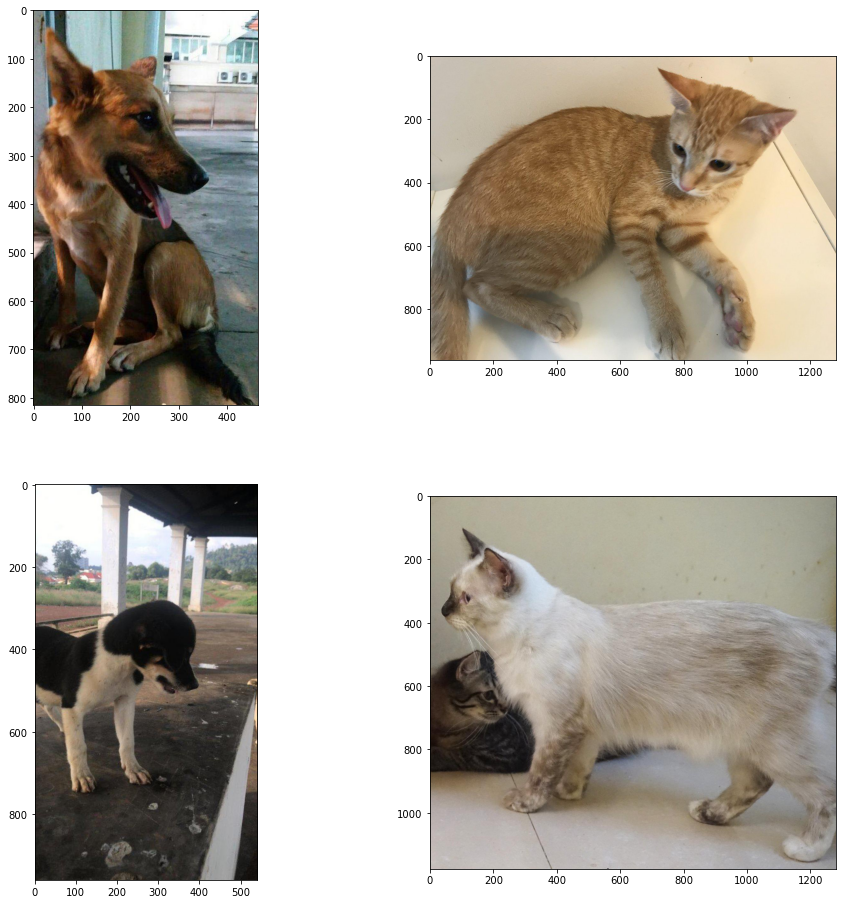

In [14]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '00df0a668441b10869f4372fd15c14f5' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + '014af4e2e2154f171c8a0e2d30ebb420' + '.jpg')
plt.imshow(img)
ax3 = fig.add_subplot(2, 2, 3)
img = plt.imread('train/' + '0185e6b6800c2af68dc1e055d91517be' + '.jpg')
plt.imshow(img)
ax4 = fig.add_subplot(2, 2, 4)
img = plt.imread('train/' + '019e7f286c9a3bd4d5a66b662b9465ee' + '.jpg')
plt.imshow(img)
plt.show()

### Eyes

In [15]:
eyetrain = train[train[predictors].sum(axis=1) == 1]
eyetrain[eyetrain['Eyes'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
323   08c3e0831974f24b1c096d2453355924             0     1     0     0   
4417  709aea1370fe4bc076506b7616a81ca0             0     1     0     0   
5347  897f3fd5a6138a18988b3db6a7f01fc7             0     1     0     0   
5791  95eada5448c8a64615c0d4ef86af5e26             0     1     0     0   
7269  bb1c4d5aaf6cd3731507d3c4bc4ad394             0     1     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
323        0          0      0        0      0          0     0     0   
4417       0          0      0        0      0          0     0     0   
5347       0          0      0        0      0          0     0     0   
5791       0          0      0        0      0          0     0     0   
7269       0          0      0        0      0          0     0     0   

      Pawpularity  
323            25  
4417           28  
5347           39  
5791           18  
7269           24

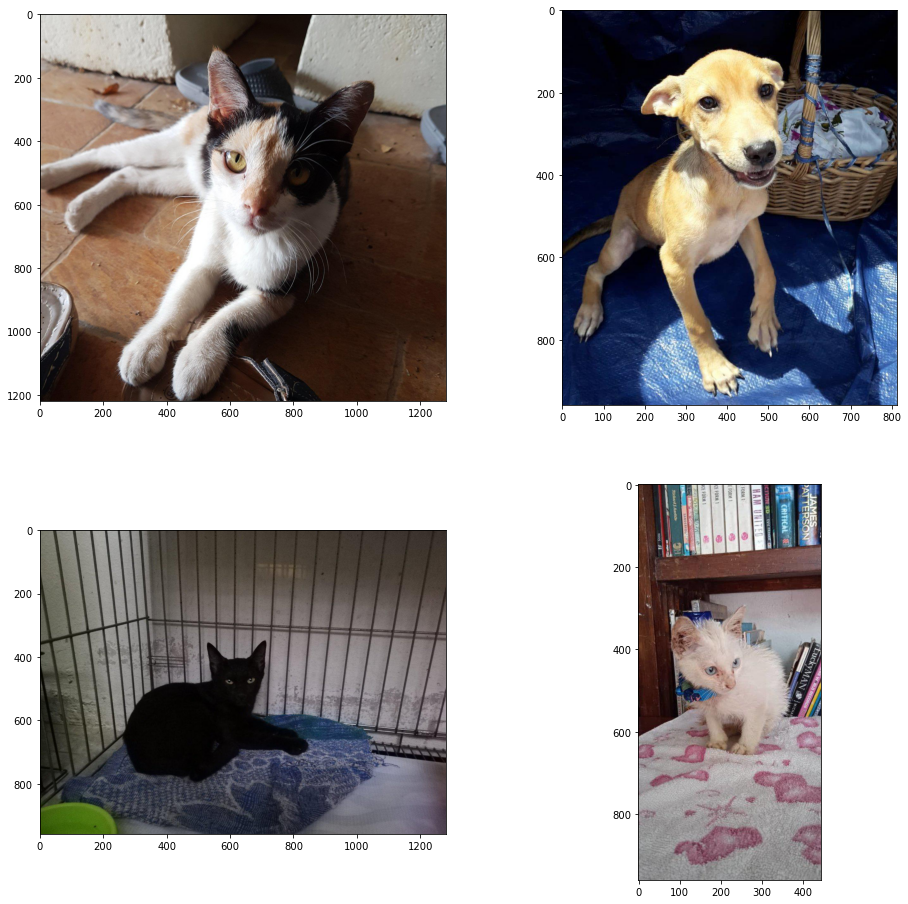

In [16]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '08c3e0831974f24b1c096d2453355924' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'bb1c4d5aaf6cd3731507d3c4bc4ad394' + '.jpg')
plt.imshow(img)
ax3 = fig.add_subplot(2, 2, 3)
img = plt.imread('train/' + '897f3fd5a6138a18988b3db6a7f01fc7' + '.jpg')
plt.imshow(img)
ax4 = fig.add_subplot(2, 2, 4)
img = plt.imread('train/' + '95eada5448c8a64615c0d4ef86af5e26' + '.jpg')
plt.imshow(img)
plt.show()

### Action

In [17]:
actiontrain = train[train[predictors].sum(axis=1) == 1]
actiontrain[actiontrain['Action'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
5348  897fb21b7475ba6a586a8b46ac20f63c             0     0     0     0   
5359  89c6d3bb72f478a8df010d8abfece3bb             0     0     0     0   
6714  ad1362089c0b9e4a50ea15e2219c2907             0     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
5348       1          0      0        0      0          0     0     0   
5359       1          0      0        0      0          0     0     0   
6714       1          0      0        0      0          0     0     0   

      Pawpularity  
5348           27  
5359           33  
6714          100

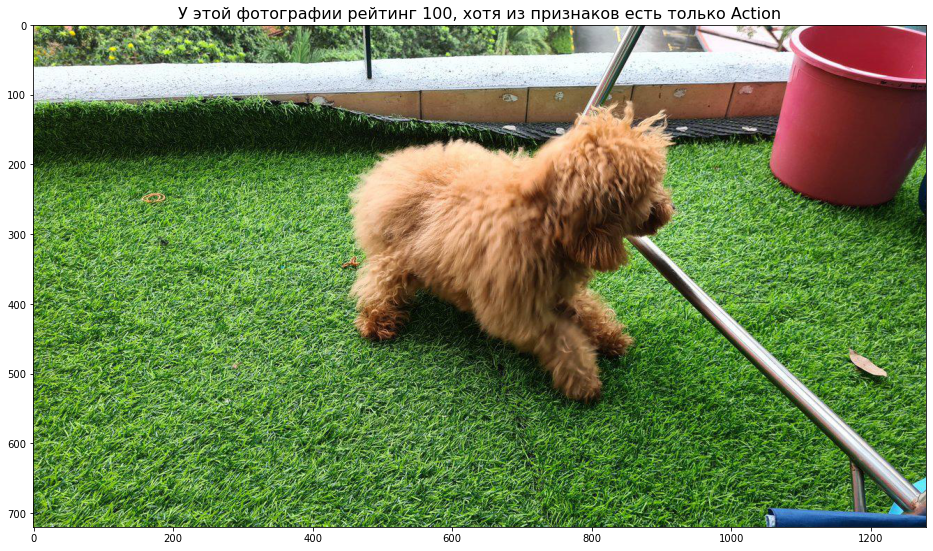

In [18]:
plt.figure(figsize=(16, 16))
img = plt.imread('train/' + 'ad1362089c0b9e4a50ea15e2219c2907' + '.jpg')
plt.imshow(img)
plt.title('У этой фотографии рейтинг 100, хотя из признаков есть только Action', fontsize=16)
plt.show()

### Face

In [19]:
face_train = train[train[predictors].sum(axis=1) == 1]
face_train[actiontrain['Face'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
223   0621169e2b2f2a7f051edd692f05a25a             0     0     1     0   
247   06c0618b3162412231114d00ac612216             0     0     1     0   
589   0f54a5dbb2d1b5efb390729b3837f450             0     0     1     0   
603   0f96a85ab1341bca42eadf67c5e02b47             0     0     1     0   
708   12306a893d396ade1351dfe6318291a4             0     0     1     0   
...                                ...           ...   ...   ...   ...   
9261  efc746ea9c8e390ef1260df8e1a5ae93             0     0     1     0   
9370  f2bafdaf4f3b89812095140d2c914a25             0     0     1     0   
9586  f7903a7d6be4a636f8c28fd23b4951ec             0     0     1     0   
9710  faa83ed873a0c3f6601626fc8cd1efee             0     0     1     0   
9724  fb1b27687118f54117255740e213ab9d             0     0     1     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
223        0          0      0        0      0          0     0     0   
247        0          0      0        0      0          0     0     0   
589        0          0      0        0      0          0     0     0   
603        0          0      0        0      0          0     0     0   
708        0          0      0        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9261       0          0      0        0      0          0     0     0   
9370       0          0      0        0      0          0     0     0   
9586       0          0      0        0      0          0     0     0   
9710       0          0      0        0      0          0     0     0   
9724       0          0      0        0      0          0     0     0   

      Pawpularity  
223            12  
247            21  
589            37  
603             3  
708            22  
...           ...  
9261           33  
9370           46  
9586          100  
9710           27  
9724           31  

[75 rows x 14 columns]

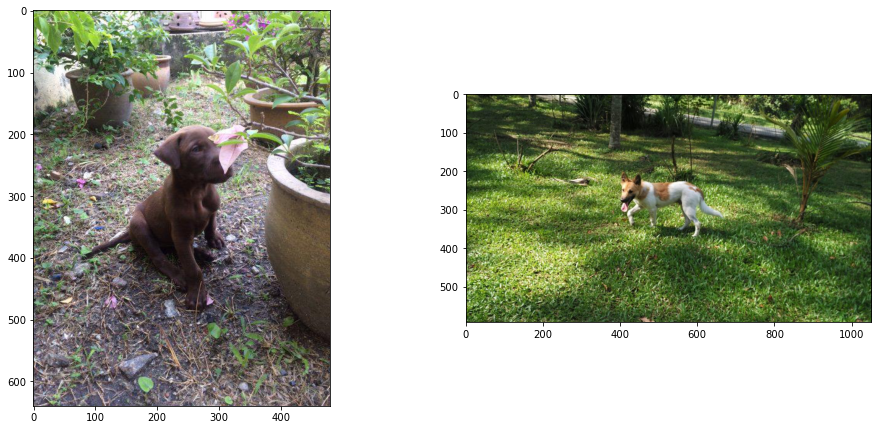

In [20]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '0f96a85ab1341bca42eadf67c5e02b47' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'f7903a7d6be4a636f8c28fd23b4951ec' + '.jpg')
plt.imshow(img)

Можно сделать предположение, что фотографии, в которых преобладает зеленая яркая трава - выглядят намного популярней.

### Accessory

In [21]:
accessory_train = train[train[predictors].sum(axis=1) == 1]
accessory_train[accessory_train['Accessory'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
1753  2c98b8a0e1deedffdf834fd748cf74dc             0     0     0     0   
5344  8963d1b06804525bc71d8343623bc355             0     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
1753       0          1      0        0      0          0     0     0   
5344       0          1      0        0      0          0     0     0   

      Pawpularity  
1753           40  
5344           30

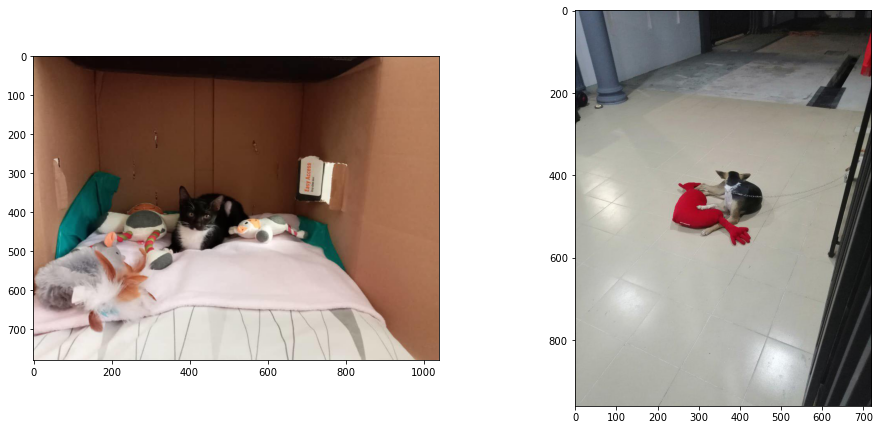

In [22]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '8963d1b06804525bc71d8343623bc355' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + '2c98b8a0e1deedffdf834fd748cf74dc' + '.jpg')
plt.imshow(img)

### Collage

In [23]:
collage_train = train[train[predictors].sum(axis=1) == 1]
collage_train[collage_train['Collage'] == 1]

Empty DataFrame
Columns: [Id, SubjectFocus, Eyes, Face, Near, Action, Accessory, Group, Collage, Human, Occlusion, Info, Blur, Pawpularity]
Index: []

### Human

In [24]:
human_train = train[train[predictors].sum(axis=1) == 1]
human_train[human_train['Human'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
997   198114b4ec9512f42d970ea8568b3357             0     0     0     0   
2364  3ce8f6925d77279375900a975e379db2             0     0     0     0   
4694  78c090320f0d5c140cc1f0ea69102893             0     0     0     0   
7571  c34fa423573802c6c046d890788f0a44             0     0     0     0   
9101  eb454fca70c34692608ddcc5ce25c377             0     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
997        0          0      0        0      1          0     0     0   
2364       0          0      0        0      1          0     0     0   
4694       0          0      0        0      1          0     0     0   
7571       0          0      0        0      1          0     0     0   
9101       0          0      0        0      1          0     0     0   

      Pawpularity  
997            21  
2364           36  
4694           37  
7571           35  
9101           17

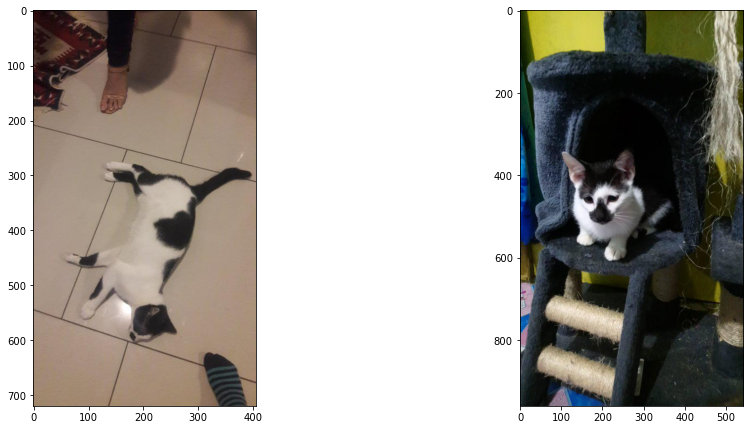

In [25]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + 'eb454fca70c34692608ddcc5ce25c377' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + '78c090320f0d5c140cc1f0ea69102893' + '.jpg')
plt.imshow(img)

### Oclusion

In [26]:
occlusion_train = train[train[predictors].sum(axis=1) == 1]
occlusion_train[occlusion_train['Occlusion'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
362   09c303eb9a57759d792682416b87f133             0     0     0     0   
1334  220b47b673787e13907a4674e7b926dc             0     0     0     0   
2866  49a9f3a2520645291a84055a0aefd2f3             0     0     0     0   
3440  58fcd15fc13f270666239c330b74c59e             0     0     0     0   
5222  8687474a0aabddf824d297816e83db05             0     0     0     0   
6187  9fe537d5642cc4f3dbb93d43b23f0112             0     0     0     0   
8379  d8eb603ed9e38797cc93ae8a7125febb             0     0     0     0   
9668  f9b6d640b2c32b8c35fe7f8a854f85a7             0     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
362        0          0      0        0      0          1     0     0   
1334       0          0      0        0      0          1     0     0   
2866       0          0      0        0      0          1     0     0   
3440       0          0      0        0      0          1     0     0   
5222       0          0      0        0      0          1     0     0   
6187       0          0      0        0      0          1     0     0   
8379       0          0      0        0      0          1     0     0   
9668       0          0      0        0      0          1     0     0   

      Pawpularity  
362            21  
1334           56  
2866           19  
3440           28  
5222           31  
6187           25  
8379           19  
9668           26

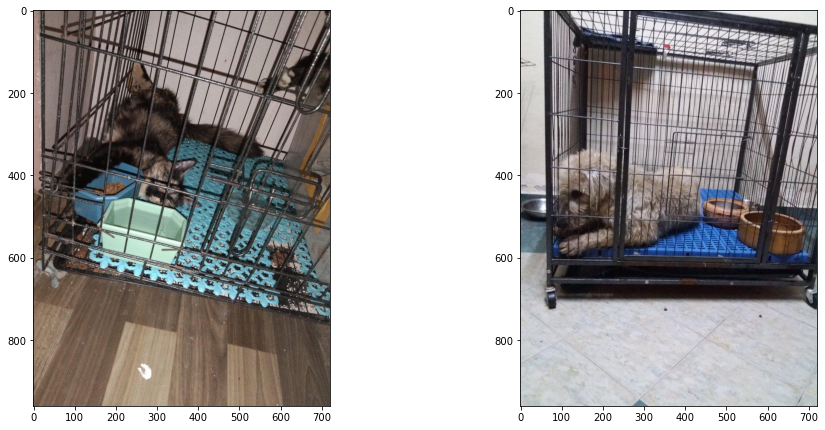

In [27]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '49a9f3a2520645291a84055a0aefd2f3' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + '220b47b673787e13907a4674e7b926dc' + '.jpg')
plt.imshow(img)

### Info

In [28]:
info_train = train[train[predictors].sum(axis=1) == 1]
info_train[info_train['Info'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
3322  55cb18bfe641205c242a7ac74fc267a7             0     0     0     0   
8524  dcc591ae039669831ef80024d4aa7adf             0     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
3322       0          0      0        0      0          0     1     0   
8524       0          0      0        0      0          0     1     0   

      Pawpularity  
3322           24  
8524           27

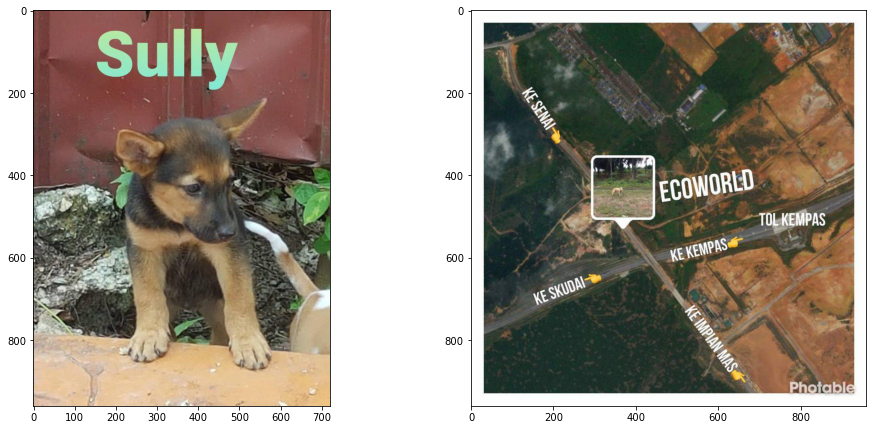

In [29]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '55cb18bfe641205c242a7ac74fc267a7' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'dcc591ae039669831ef80024d4aa7adf' + '.jpg')
plt.imshow(img)

### Blur

In [30]:
blur_train = train[train[predictors].sum(axis=1) == 1]
blur_train[blur_train['Blur'] == 1]

Id  SubjectFocus  Eyes  Face  Near  \
418   0b04f9560a1f429b7c48e049bcaffcca             0     0     0     0   
1414  246b143a82bb05a3ff52ee0839acc4ce             0     0     0     0   
3669  5dc85cd881e9352aff9c9114b8974d4b             0     0     0     0   
3726  5f0f49ec2f95f9cccb8d9814c194e434             0     0     0     0   
4707  7902e1334658f22efd44ce495bb0d698             0     0     0     0   
5772  958347582af6ece8a5dd7ebd0f2cf3ef             0     0     0     0   
6072  9d1ded46129d32419def2862f3803165             0     0     0     0   
6454  a6aa66ebb28a9bcecf72aff5b90eb68d             0     0     0     0   
7276  bb3f29ef9e0012df0fa7e580b7580a45             0     0     0     0   
7507  c19931522ce6b68f6da376459cde9c8f             0     0     0     0   
9147  ec64e3c4d306213c94db5efd24849b37             0     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
418        0          0      0        0      0          0     0     1   
1414       0          0      0        0      0          0     0     1   
3669       0          0      0        0      0          0     0     1   
3726       0          0      0        0      0          0     0     1   
4707       0          0      0        0      0          0     0     1   
5772       0          0      0        0      0          0     0     1   
6072       0          0      0        0      0          0     0     1   
6454       0          0      0        0      0          0     0     1   
7276       0          0      0        0      0          0     0     1   
7507       0          0      0        0      0          0     0     1   
9147       0          0      0        0      0          0     0     1   

      Pawpularity  
418            24  
1414            8  
3669           22  
3726           15  
4707            6  
5772           21  
6072           81  
6454           26  
7276           22  
7507           45  
9147          100

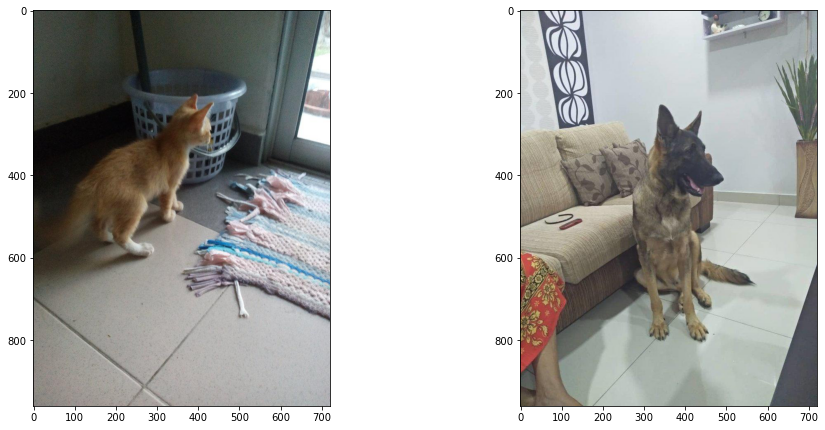

In [31]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '7902e1334658f22efd44ce495bb0d698' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'ec64e3c4d306213c94db5efd24849b37' + '.jpg')
plt.imshow(img)

## Поиск фотографий с зеленой травой


In [32]:
import numpy as np
import cv2
import webcolors
import time
import matplotlib.pyplot as plt

In [33]:
image = plt.imread('train/' + 'f7903a7d6be4a636f8c28fd23b4951ec' + '.jpg')

def bgr_to_hex(bgr):
   rgb =list(bgr)
   rgb.reverse()
   return webcolors.rgb_to_hex(tuple(rgb))

def FindColors(image):
    color_hex = []
    for i in image:
        for  j in i:
            j = list(j)
            color_hex.append(bgr_to_hex(tuple(j)))
    return color_hex

color_list = FindColors(image)
len(color_list)

622784

In [34]:
color_list = list(map(list, color_list))
gr_col = 0
for color in color_list:
    if color[3] in ['a', 'b', 'c', 'd', 'e', 'f'] and color[4] in ['a', 'b', 'c', 'd', 'e', 'f']:
        gr_col+=1
print(gr_col > len(color_list) / 40)

True


In [35]:
def grass(img):
    image = plt.imread('train/' + img + '.jpg')
    color_list = FindColors(image)
    color_list = list(map(list, color_list))
    gr_col = 0
    for color in color_list:
        if color[3] == 'f' and color[4] == 'f':
            gr_col+=1
    return int(gr_col > len(color_list) / 200)

In [36]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [37]:
# This was maden for 3 days (don't compile)
#grass_list = list()
#for i in log_progress(train.Id, every=1):
#    grass_list.append(int(grass(i)))
new_train = pd.read_csv('new_train.csv')
grass_list = new_train.Grass
new_train

Id  SubjectFocus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0             0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db             0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e             0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246             0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2             0     0     0     1   
...                                ...           ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57             0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45             0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20             0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a             0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228             0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  Grass  
0              63      0  
1              42      0  
2              28      0  
3              15      0  
4              72      0  
...           ...    ...  
9907           15      0  
9908           70      0  
9909           20      0  
9910           20      0  
9911           30      0  

[9912 rows x 15 columns]

In [38]:
grass_array = np.array(grass_list)
grass_array

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
new_train = train.copy()
new_train['Grass'] = grass_array
# new_train.to_csv('new_train.csv', index=False)
new_train

Id  SubjectFocus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0             0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db             0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e             0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246             0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2             0     0     0     1   
...                                ...           ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57             0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45             0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20             0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a             0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228             0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  Grass  
0              63      0  
1              42      0  
2              28      0  
3              15      0  
4              72      0  
...           ...    ...  
9907           15      0  
9908           70      0  
9909           20      0  
9910           20      0  
9911           30      0  

[9912 rows x 15 columns]

In [40]:
new_train.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
#test.columns[1:]

Index(['SubjectFocus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
      dtype='object')

In [41]:
predictors = new_train.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
new_train['Group'] = (train['Group'] == 0).astype(int)
X = new_train[predictors].copy()
y = new_train.Pawpularity.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_predictors = model.predict(X_val)
mean_absolute_error(y_val, y_predictors)

14.311394227955336

In [42]:
output = pd.DataFrame(test.Id)
predictors = test.columns[1:]
# test['Score'] = df.Action * 12 + df.SubjectFocus * 11 + df.Face * 10 + df.Near * 9 + df.Accessory * 8 + df.Blur * 7 + df.Info * 6 + df.Collage * 5 + df.Group * 4 + df.Occlusion * 3 + df.Eyes * 2 + df.Human
X_test = test[predictors].copy()
output['Pawpularity'] = model.predict(X_test)
output

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3    36.038354
1  43a2262d7738e3d420d453815151079e    35.140835
2  4e429cead1848a298432a0acad014c9d    34.644541
3  80bc3ccafcc51b66303c2c263aa38486    39.601486
4  8f49844c382931444e68dffbe20228f4    38.003443
5  b03f7041962238a7c9d6537e22f9b017    41.281388
6  c978013571258ed6d4637f6e8cc9d6a3    34.112429
7  e0de453c1bffc20c22b072b34b54e50f    36.794351

#### Идея добавить параеметр наличия травы не оправдал себя или оформлен некорректно

In [43]:
train[train.Pawpularity == 1]

Id  SubjectFocus  Eyes  Face  Near  \
2442  3ed899a8334a8e5c74f4a554f3ce6f08             0     1     1     1   
3232  53b536999aecd800cfda720f3ca363cb             0     1     1     1   
4235  6c159aede3df25fdbe781431aabcfc67             0     1     1     1   
8674  e0a1efdaf4fbed8659b6d23994ee346e             0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
2442       0          0      0        0      0          0     0     0   
3232       0          0      0        0      0          0     0     0   
4235       0          0      0        0      0          0     0     0   
8674       0          0      0        0      1          1     0     0   

      Pawpularity  
2442            1  
3232            1  
4235            1  
8674            1

In [44]:
train[(train['Occlusion'] == 1) & (train['Human'] == 1) & (train['Pawpularity'] == 10)]

Id  SubjectFocus  Eyes  Face  Near  \
1419  248419217523a1a6f782cf43fd04c2a1             0     1     1     1   
1828  2e81ce009364518c4ba9c7746e044d66             0     1     1     1   
3261  547c30b487c71b7e25a30de9e008b6ae             0     0     0     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
1419       0          0      0        0      1          1     0     0   
1828       0          0      0        0      1          1     0     0   
3261       0          0      0        0      1          1     0     0   

      Pawpularity  
1419           10  
1828           10  
3261           10

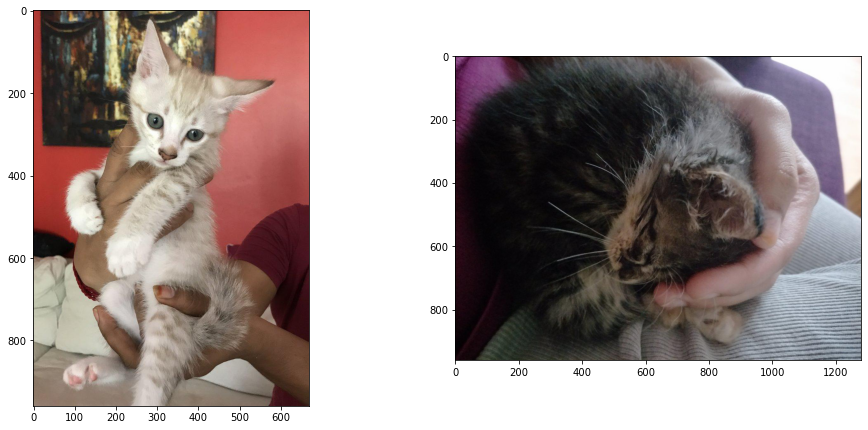

In [45]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '248419217523a1a6f782cf43fd04c2a1' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + '547c30b487c71b7e25a30de9e008b6ae' + '.jpg')
plt.imshow(img)

#### Похоже, так же нужно добавить наличие пузика в кадре

In [46]:
train[train['Pawpularity'] == 100]

Id  SubjectFocus  Eyes  Face  Near  \
19    00768659c1c90409f81dcdecbd270513             0     1     1     0   
50    013f86ed0e765b189990d3d5ac28bd7d             0     0     0     1   
86    0254f54b148543442373d5aad45b2d1a             0     1     1     1   
182   04fef9f129bc6e4b90644d4290fde8c3             0     1     1     1   
227   063d79b149f4d163eae86f777a39a42f             0     0     1     1   
...                                ...           ...   ...   ...   ...   
9684  fa27d0eeeec835a00853d382f8777b19             0     1     1     1   
9725  fb1b85c23f5cc8a079387ff575b67b50             0     1     1     1   
9836  fde75ba22f491d31c9267e59f6cbfe1a             0     1     1     1   
9843  fe200aff478f55ca4bcf77d9dade1217             0     1     1     1   
9878  fedb56afb73e703dbcad66406943b45f             0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
19         0          0      0        0      0          0     0     0   
50         0          0      1        0      0          0     0     0   
86         0          0      0        0      0          0     0     0   
182        0          0      0        0      0          0     0     0   
227        0          0      0        0      0          0     0     1   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9684       0          0      0        0      0          0     0     0   
9725       0          0      0        0      0          0     1     0   
9836       0          0      0        0      0          0     0     0   
9843       0          0      0        0      0          0     0     0   
9878       0          0      0        0      0          0     0     0   

      Pawpularity  
19            100  
50            100  
86            100  
182           100  
227           100  
...           ...  
9684          100  
9725          100  
9836          100  
9843          100  
9878          100  

[288 rows x 14 columns]

In [47]:
predictors = train.columns[1:-1]
train[(train[predictors].sum(axis=1) == 1) & (train['SubjectFocus'] == 1)]

Id  SubjectFocus  Eyes  Face  Near  \
9495  f56b7ba8c1356db52b38c19960551afc             1     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
9495       0          0      0        0      0          0     0     0   

      Pawpularity  
9495           30

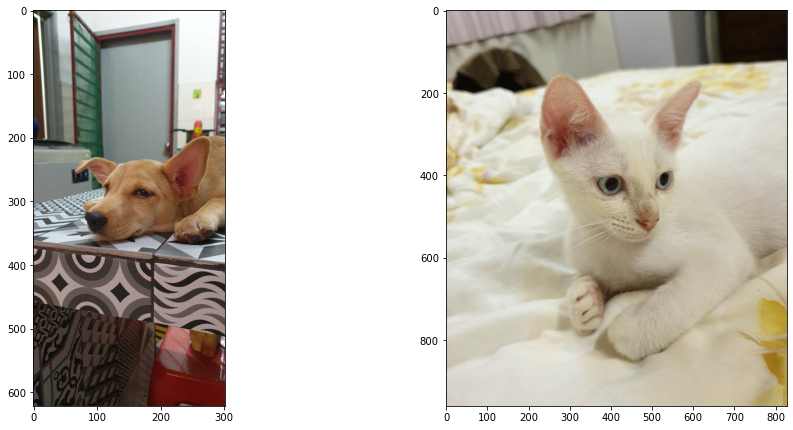

In [48]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '05a13ce91dcd00be196c448857f2ef34' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'f56b7ba8c1356db52b38c19960551afc' + '.jpg')
plt.imshow(img)

In [49]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 2)]

Id  SubjectFocus  Eyes  Face  Near  \
234   06680d201ae110be39617fc7b6ee53c4             1     0     0     1   
772   13aff9dd79e84f2c220a9ab587897fe9             1     0     0     1   
3773  6030abd068ca6b5f96397aaacb78314e             1     0     0     1   
4784  7b191a7aba2e259b97987b9d0827731b             1     0     0     1   
5461  8cb7385c0afa4ebf71fb93ce5adba2c9             1     0     0     1   
7291  bba74bfa6a991a9d0d52250b97ba44ff             1     0     0     1   
7603  c420c7158cba6b82dc5b3cb652a866c9             1     0     0     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
234        0          0      0        0      0          0     0     0   
772        0          0      0        0      0          0     0     0   
3773       0          0      0        0      0          0     0     0   
4784       0          0      0        0      0          0     0     0   
5461       0          0      0        0      0          0     0     0   
7291       0          0      0        0      0          0     0     0   
7603       0          0      0        0      0          0     0     0   

      Pawpularity  
234            41  
772            33  
3773           32  
4784           53  
5461           26  
7291           39  
7603           65

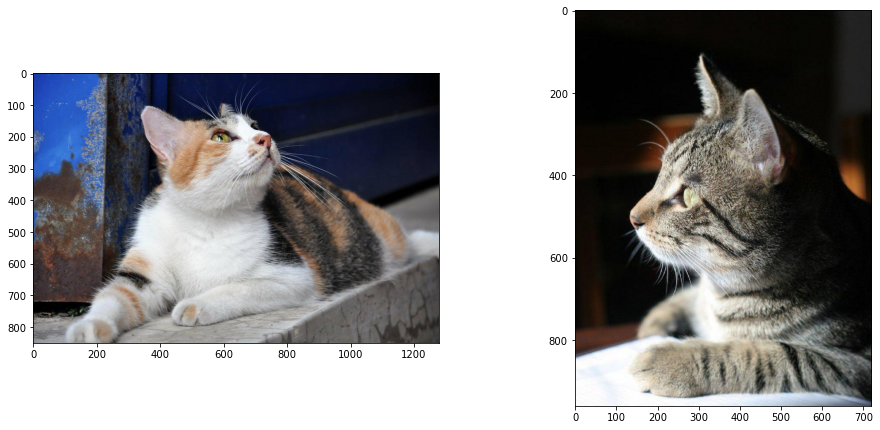

In [50]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
img = plt.imread('train/' + '8cb7385c0afa4ebf71fb93ce5adba2c9' + '.jpg')
plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
img = plt.imread('train/' + 'c420c7158cba6b82dc5b3cb652a866c9' + '.jpg')
plt.imshow(img)

### Попробуем высчитать для каждого признакак его вес

In [51]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 1)]

Id  SubjectFocus  Eyes  Face  Near  \
9495  f56b7ba8c1356db52b38c19960551afc             1     0     0     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
9495       0          0      0        0      0          0     0     0   

      Pawpularity  
9495           30

Предположительно, если есть только один признак "SubjectFocus", то популярность будет 30

In [52]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 2)]

Id  SubjectFocus  Eyes  Face  Near  \
234   06680d201ae110be39617fc7b6ee53c4             1     0     0     1   
772   13aff9dd79e84f2c220a9ab587897fe9             1     0     0     1   
3773  6030abd068ca6b5f96397aaacb78314e             1     0     0     1   
4784  7b191a7aba2e259b97987b9d0827731b             1     0     0     1   
5461  8cb7385c0afa4ebf71fb93ce5adba2c9             1     0     0     1   
7291  bba74bfa6a991a9d0d52250b97ba44ff             1     0     0     1   
7603  c420c7158cba6b82dc5b3cb652a866c9             1     0     0     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
234        0          0      0        0      0          0     0     0   
772        0          0      0        0      0          0     0     0   
3773       0          0      0        0      0          0     0     0   
4784       0          0      0        0      0          0     0     0   
5461       0          0      0        0      0          0     0     0   
7291       0          0      0        0      0          0     0     0   
7603       0          0      0        0      0          0     0     0   

      Pawpularity  
234            41  
772            33  
3773           32  
4784           53  
5461           26  
7291           39  
7603           65

In [53]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 2)].Pawpularity.mean()

41.285714285714285

Если к одному признаку SubjectFocus добавить Near, то выйдет, в среднем, +11 к популярности

In [54]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 3)]

Id  SubjectFocus  Eyes  Face  Near  \
1663  2a728ecc560e534dfc769bc8b9a0ea82             1     1     1     0   
3508  5a7fa7cfeb8d5e32116574e6be7ecb6a             1     1     1     0   
4224  6befc3ee8c68b330456e10e5eb206e40             1     1     1     0   
6378  a4d8203c19f11367cc117ec69624eb2a             1     0     1     1   
7029  b527270bc6d68256bca2749e2e0863de             1     1     1     0   
8845  e48e3f80d56cb7d951c957de4d56a902             1     0     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
1663       0          0      0        0      0          0     0     0   
3508       0          0      0        0      0          0     0     0   
4224       0          0      0        0      0          0     0     0   
6378       0          0      0        0      0          0     0     0   
7029       0          0      0        0      0          0     0     0   
8845       0          0      0        0      0          0     0     0   

      Pawpularity  
1663           13  
3508           27  
4224           32  
6378           31  
7029           35  
8845           43

Если так же к признаку SubjectFocus и Near добавить Face, то это будет, в среднем, иметь отрицательный эффект -4.

Если к SubjectFocus добавить признаки Eyes и Face то, в среднем, эффект будет -3

In [55]:
pd.set_option('display.max_rows', None)
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 4)]

Id  SubjectFocus  Eyes  Face  Near  \
44    0117f444e6118619c4f6492cba703177             1     1     1     1   
48    01318357ff47c204f0d5c5a28e4eac77             1     1     1     1   
130   03cc3bf8d70b4c82d026fa111c4fadea             1     1     1     1   
132   03d82e64d1b4d99f457259f03ebe604d             1     1     1     1   
170   04c7819455dc899fdcc11e0d4eb2d875             1     1     1     1   
174   04da7e561eb86d14d1e96f108e1100d7             1     1     1     1   
217   06056c036db13114e7d665fe45cb58f8             1     1     1     1   
230   06581f7f85666b267020ad85fd0241f9             1     1     1     1   
233   06663a108456ffc23b983cdc783d9bd5             1     1     1     1   
288   07d2c88f20eed475fad105be6691f7bc             1     1     1     1   
332   08f523004da4fa95acfec2cc8fb41605             1     1     1     1   
359   09a4ea91c9c54bf50be1d19703f19e6f             1     1     1     1   
366   09dbd5c77af1a67baf91e56d3e8a93ca             1     1     1     1   
379   0a179efafacf11d83cea823dfedc773e             1     1     1     1   
385   0a36f2cb29809d48b0976c2f9346c9d8             1     1     1     1   
482   0cc43749d0d63191257891817a7c3dc0             1     1     1     1   
488   0cea3f61a6268efa8c6c7e5967199aa0             1     1     1     1   
491   0d014b8fd08990a636d8d61bd063bec0             1     1     1     1   
595   0f734ffd3f32c3975d83dcaa1ef91062             1     1     1     1   
601   0f8cc9aebe82a67f3433e5cd76224047             1     1     1     1   
602   0f93d1482d7fb9f2b6a5085ee729142b             1     1     1     1   
623   103c321add6f3e2191920bcc2fd1c9fc             1     1     1     1   
631   105b5c5dd082da3221769c07d8c33d92             1     1     1     1   
689   11cccac570890b0aabf7e702df5e841c             1     1     1     1   
877   1639154afdda0bc0f5c9ca8843667e9f             1     1     1     1   
880   164f9ea1fef0ea9e68ef715e763005c8             1     1     1     1   
917   17294aa3ea03519e7b03884493731de9             1     1     1     1   
950   180d618bb956cd5c58a9ae9329c9ae3a             1     1     1     1   
984   191a55d9d4dcf2f39df0f6e0c31ad43f             1     1     1     1   
1000  199b6e37ebf74285617461c0e37e1eb2             1     1     1     1   
1022  1a1a3d889af16a041e26726dee299df3             1     1     1     1   
1045  1ad0553a2470ec6be9c2a657f3e366bd             1     1     1     1   
1049  1ae7b75fa043600469876abd2121952f             1     1     1     1   
1136  1d1f953d28f78f812f3ad3bcb98b5c7d             1     1     1     1   
1152  1d62cd9439bb452390ece13419a1861e             1     1     1     1   
1190  1e93d87f931fc6069fb37ccb79ac68c4             1     1     1     1   
1234  1fecdef9d99947d7ce6e6c73d4918397             1     1     1     1   
1287  212e7be4792dab70f09127d456f93259             1     1     1     1   
1313  21ad381c0421c30b1ce3f4e8ecf87223             1     1     1     1   
1327  21f8038309981512224530de3090168f             1     1     1     1   
1388  23a3d5e4b8ed3bc3be0e0c38306d7ea6             1     1     1     1   
1426  24af0d24d0459baf573f552918b07353             1     1     1     1   
1522  26fbea38527e329ccc2b6cda8ce37e88             1     1     1     1   
1559  27c6401ab71aafc879804b6c4f039162             1     1     1     1   
1600  28dd9734e29580aaf5f56c4a612ef98e             1     1     1     1   
1656  2a3e9698f2ef23156edd0ae524e84232             1     1     1     1   
1674  2aa8117d6b9d7251842c33805f2f659f             1     1     1     1   
1746  2c69f17538d3622ab8015ae3301e9de5             1     1     1     1   
1814  2e0bbeb500219bdda440e21b21724458             1     1     1     1   
1868  2f77712c52a4269edbda6cac1378e698             1     1     1     1   
1875  2fae7fce82368e49c7068298bf32fccb             1     1     1     1   
1964  327e812f9b948392534175bb1df51b95             1     1     1     1   
2015  340d1735ba2f23f322b0025a630fd30f             1     1     1     1   
2022  34525157157de72161c447829ce73850  

In [56]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 4)].Pawpularity.mean()

38.130630630630634

Если добавить к SubjectFocus Eyes, Face и Near, то, в среднем, получится +8 --> 38, что сходится с нашими предыдущими результатами

In [57]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 5) & (train['Action'] == 1)].Pawpularity.mean()

25.0

Если еще и к SubjectFocus, Eyes, Face, Near добавить Action, то получится -13

In [58]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 5) & (train['Accessory'] == 1)].Pawpularity.mean()

30.32

Если еще и к SubjectFocus, Eyes, Face, Near добавить Accessory, то получится -8

In [59]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 5) & (train['Group'] == 1)].Pawpularity.mean()

33.6

Если еще и к SubjectFocus, Eyes, Face, Near добавить Group, то получится -5

In [60]:
train[(train['SubjectFocus'] == 1) & (train[predictors].sum(axis=1) == 5) & (train['Info'] == 1)]#.Pawpularity.mean()

Id  SubjectFocus  Eyes  Face  Near  Action  \
76  01d3b1337b973c204125f409286d8e54             1     1     1     1       0   

    Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
76          0      0        0      0          0     1     0           26

Если еще и к SubjectFocus, Eyes, Face, Near добавить Info, то получится -12

In [62]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 1)].Pawpularity.mean()

26.8

In [63]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 2) & (train['Face'] == 1)].Pawpularity.mean()

37.68690095846645

In [64]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 2) & (train['Near'] == 1)].Pawpularity.mean()

21.833333333333332

In [66]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 2) & (train['Accessory'] == 1)].Pawpularity.mean()

13.0

In [70]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 2) & (train['Occlusion'] == 1)].Pawpularity.mean()

58.0

In [71]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 2) & (train['Info'] == 1)].Pawpularity.mean()

46.0

In [76]:
train[(train['Eyes'] == 1) & (train[predictors].sum(axis=1) == 3) & (train['Face'] == 1) & (train['Near'] == 1)].Pawpularity.mean()

37.96590330788804